# Product Recognition on Store Shelves

### Marco Scaramuzzi Mat:

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify boxes of cereals of different brands from one picture of a store shelf. For each type of product displayed in the shelf the system should report:

1. Number of instances.
2. Dimension of each instance (width and height of the bounding box that enclose them in pixel).

In [43]:
#Import required modules
import numpy as np
from matplotlib import pyplot as plt
import cv2
from typing import Tuple
from collections import defaultdict
from glob import glob

import plot_utils 
import image_loading 


# Only for jupyter notebook visualization
%matplotlib inline



Enviromental variables

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
MODELS = "models/"
SCENES_FOLDER = "scenes/step_A/"
MODEL_IDX = [0, 1, 11, 19, 24, 25,26]
SCENE_LETTER = "e"

### Test on scene image: {e1.png, e2.png, e3.png, e4.png, e5.png}


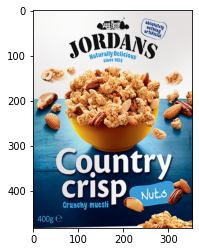

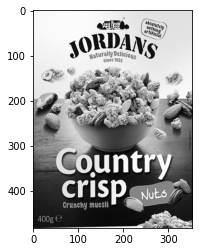

In [46]:
models, models_grey = image_loading.get_models_image(MODELS, MODEL_IDX)
random_img = np.random.randint(0, len(models))


plt.imshow(models[random_img], cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(models_grey[random_img], cmap='gray', vmin=0, vmax=255)
plt.show()

In [47]:
# def plot_color_bg_img(scenes_folder: str, scene_letter: str) -> None:
#     """_summary_

#     Args:None if scene_letter
#         scenes (list): _description_
#         scene_letter (str): _description_

#     Returns:
#         _type_: _description_
#     """    
#     scenes, scenes_grey = image_loading.get_scenes_image(scenes_folder, scene_letter)
#     random_img_idx = np.random.randint(0, len(scenes))
#     random_img_col, random_img_bg = scenes[random_img_idx], scenes_grey[random_img_idx]
    
#     plt.imshow(random_img_col, cmap='gray', vmin=0, vmax=255)
#     plt.show()
#     plt.imshow(random_img_bg, cmap='gray', vmin=0, vmax=255)
#     plt.show()
    
#     return None

In [48]:
# plot_color_bg_img(SCENES_FOLDER, SCENE_LETTER)

### Example image

In [49]:
scenes, scenes_grey = image_loading.get_scenes_image(SCENES_FOLDER)
img_train = scenes[0]

In [50]:
np.random.seed(42)


random_img = np.random.randint(0, len(models))
img_query =  models[random_img]

### 1. Keypoint Detection

Common schema:

1. Compute a saliency score for each pixel location based on the response to different mathematical operators. 
2. Keep only the points that are local maxima.
3. For each keypoint estimate the ‘scale’ at which it is salient (scale invariance) and the orientation (rotation invariance).   

Let us now find keypoints in the scene based on the sift detector. We first initialize the SIFT detector object in the following way:


In [51]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

In [52]:
# find the keypoints and descriptors with SIFT
kp_query = sift.detect(img_query)

In [53]:
print(len(kp_query)) # Number of keypoints

print(kp_query[0].pt) # Location of the keypoint

print(kp_query[0].size) # Scale

print(kp_query[0].angle) # Rotation

1084
(2.690967559814453, 390.980712890625)
2.139641046524048
99.47015380859375


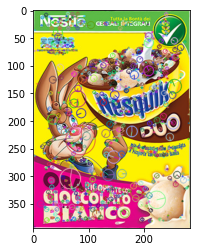

In [54]:
# Visualize keypoints with drawKeypoints.
#Use flag DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS to show scale and orientation of keypoints.
img_visualization = cv2.drawKeypoints(img_query, kp_query, None, 
                                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_visualization)
plt.show()

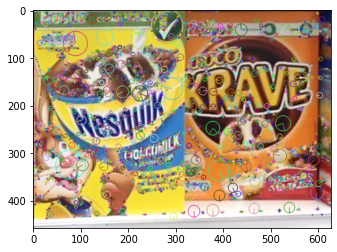

In [55]:
kp_train = sift.detect(img_train)

img=cv2.drawKeypoints(img_train,kp_train,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.show()

### Keypoints description

In [56]:
# Describing keypoints for query and train images
kp_query, des_query = sift.compute(img_query, kp_query)
kp_train, des_train = sift.compute(img_train, kp_train)

In [57]:
print("Number of query descriptors: ", len(des_query))
print("Dimensionality of a SIFT descriptor: ", des_query[0].shape)
print("Type of the descriptor: ", des_query[0].dtype)

Number of query descriptors:  1084
Dimensionality of a SIFT descriptor:  (128,)
Type of the descriptor:  float32


### Feature Matching


In [58]:
# Defining index for approximate kdtree algorithm
FLANN_INDEX_KDTREE = 1

# Defining parameters for algorithm 
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# Defining search params.
# checks=50 specifies the number of times the trees in the index should be recursively traversed.
# Higher values gives better precision, but also takes more time
search_params = dict(checks = 50)

# Initializing matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching and finding the 2 closest elements for each query descriptor.
matches = flann.knnMatch(des_query,des_train,k=2)

In [59]:
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

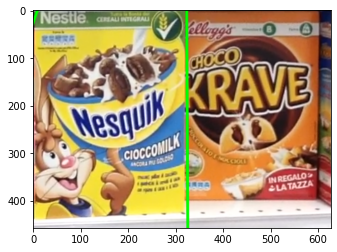

In [65]:
# Checking if we found enough matching
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    # building the corrspondences arrays of good matches
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    # Using RANSAC to estimate a robust homography. 
    # It returns the homography M and a mask for the discarded points
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Mask of discarded point used in visualization
    matchesMask = mask.ravel().tolist()
    
    # Corners of the query image
    h,w, _ = img_query.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    
    # Projecting the corners into the train image
    dst = cv2.perspectiveTransform(pts,M)
    
    # Drawing the bounding box
    img_train_sift = cv2.polylines(img=img_train, pts=[np.int32(dst)],
                                   isClosed=True, color=(0,255,0),thickness=2, lineType=cv2.LINE_AA)
    plt.imshow(img_train_sift, cmap='gray', vmin=0, vmax=255)
    plt.show()
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

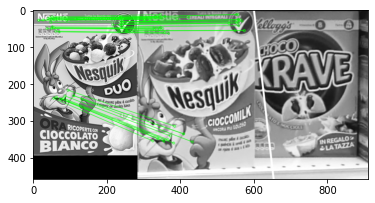

In [122]:
# Drawing the matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None, # not draw keypoints only matching lines
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2) # not draw keypoints only lines
img3 = cv2.drawMatches(img_query,kp_query,img_train,kp_train,good,None,**draw_params)
plt.imshow(img3, 'gray')
plt.show()